# Consumer-Resource dynamics


> This chapter follows on from the [Species Interactions chapter](interactions.ipynb) by turning “interaction stories” into explicit analyses of feasibility and stability.
>
> We start with the phenomenological Lotka–Volterra competition model as a warm-up, then reuse the same analysis toolkit for threshold phenomena, catastrophic shifts, and hysteresis.
>
> For the classic Lotka–Volterra predator–prey dynamics and numerical integration examples, also see the [Python chapter](python.ipynb) and [this Appendix](appendix-maths.ipynb).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.linalg import eigvals

---

## Lotka–Volterra Competition: geometry in the phase plane

### Model and isoclines

The Lotka–Volterra (LV) competition model is a minimal, phenomenological description of two populations whose per-capita growth rates decline linearly with crowding from *both* conspecifics and heterospecifics. It is widely used as a first pass for understanding coexistence vs exclusion, and as a geometric introduction to phase-plane reasoning.

For

$$
\dot N_1 = r_1 N_1 (k_1 - N_1 - a N_2),\quad
\dot N_2 = r_2 N_2 (k_2 - b N_1 - N_2),
$$

the zero-growth isoclines are:

- Species 1: $\dot N_1 = 0$ for $N_1=0$ **or** $k_1 - N_1 - aN_2=0\Rightarrow N_2=(k_1-N_1)/a$
- Species 2: $\dot N_2 = 0$ for $N_2=0$ **or** $k_2 - bN_1 - N_2=0\Rightarrow N_2=k_2-bN_1$

These lines partition the $(N_1,N_2)$ plane into regions where each species increases or decreases, so you can often predict the long-term outcome by sketching the vector field qualitatively.

References: {cite:t}`Lotka1925`; {cite:t}`Volterra1926`; {cite:t}`May1973`; {cite:t}`Case2000`.


In [2]:
def lv_rhs(t, y, r1, r2, k1, k2, a, b):
    n1, n2 = y
    dn1 = r1*n1*(k1 - n1 - a*n2)
    dn2 = r2*n2*(k2 - b*n1 - n2)
    return [dn1, dn2]

def isoclines(n1_grid, k1, k2, a, b):
    return (k1 - n1_grid)/a, (k2 - b*n1_grid)

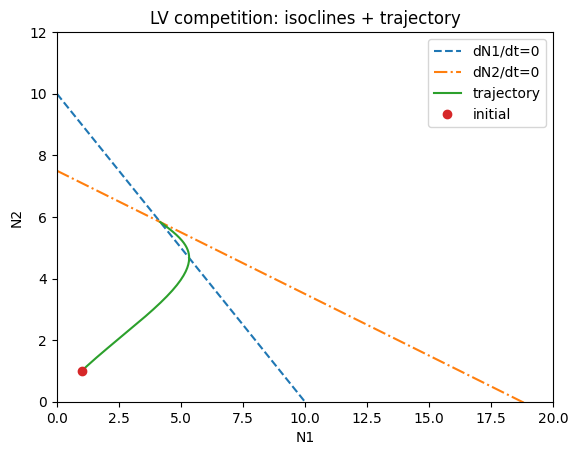

In [3]:
# Example parameter set

r1=r2=1.0
k1, k2 = 10.0, 7.5
a, b = 1.0, 0.4

y0 = [1.0, 1.0]
sol = solve_ivp(lv_rhs, (0, 10), y0, t_eval=np.linspace(0,10,800), args=(r1,r2,k1,k2,a,b), rtol=1e-9, atol=1e-12)

n1, n2 = sol.y
n1_grid = np.linspace(0, 20, 400)
iso1, iso2 = isoclines(n1_grid, k1, k2, a, b)

plt.figure()
plt.plot(n1_grid, iso1, '--', label='dN1/dt=0')
plt.plot(n1_grid, iso2, '-.', label='dN2/dt=0')
plt.plot(n1, n2, label='trajectory')
plt.plot([y0[0]],[y0[1]], marker='o', linestyle='none', label='initial')
plt.xlim(0,20); plt.ylim(0,12)
plt.xlabel("N1"); plt.ylabel("N2")
plt.title("LV competition: isoclines + trajectory")
plt.legend()
plt.show()

### Four canonical outcomes

The classical LV competition model yields four qualitative outcomes depending on how the isoclines intersect. Geometrically, the key idea is that isoclines act like “decision boundaries” for the sign of $\dot N_1$ and $\dot N_2$; the way those boundaries are nested (which one lies “outside” the other) determines whether trajectories are driven to a boundary equilibrium (exclusion) or to an interior point (coexistence).

1. **Species 1 excludes species 2**: stable equilibrium $(k_1,0)$
2. **Species 2 excludes species 1**: stable equilibrium $(0,k_2)$
3. **Stable coexistence**: a stable interior equilibrium $(N_1^*,N_2^*)$ exists
4. **Alternative stable states (bistability)**: both $(k_1,0)$ and $(0,k_2)$ are stable; an interior saddle separates basins

In the practical, parameter set 1 corresponds to stable coexistence, while parameter set 2 corresponds to alternative stable states.

References: {cite:t}`May1973`; {cite:t}`Case2000`; {cite:t}`Kot2001`.


---

## Equilibria and local stability

### Equilibria

Equilibria (fixed points) are population states where both species have zero net growth. In two-dimensional systems like this, equilibria and their stability types (stable node, saddle, etc.) provide a compact “map” of long-term behaviour.

Setting $\dot N_1=\dot N_2=0$ gives the candidate equilibria:

- $E_{00}=(0,0)$
- $E_{10}=(k_1,0)$
- $E_{01}=(0,k_2)$
- $E_{\mathrm{co}}$ = intersection of the non-trivial isoclines:

$$
\begin{bmatrix}1 & a\\ b & 1\end{bmatrix}
\begin{bmatrix}N_1^*\\ N_2^*\end{bmatrix}
=
\begin{bmatrix}k_1\\ k_2\end{bmatrix}
\Rightarrow
N_1^*=\frac{k_1-a k_2}{1-ab},\quad
N_2^*=\frac{k_2-b k_1}{1-ab}.
$$

Feasibility requires $N_1^*,N_2^* \ge 0$.

References: {cite:t}`May1973`; {cite:t}`Strogatz1994`; {cite:t}`Kot2001`.


### Jacobian and eigenvalues

Local stability is assessed by linearising the system near an equilibrium. The Jacobian $J$ captures how small perturbations grow or shrink; its eigenvalues determine whether trajectories return to the equilibrium (stable) or depart (unstable). This is the standard linear-stability toolkit used throughout dynamical systems and theoretical ecology.

Define $f_1(N_1,N_2)=r_1N_1(k_1-N_1-aN_2)$ and $f_2(N_1,N_2)=r_2N_2(k_2-bN_1-N_2)$.

The Jacobian is:

$$
J=
\begin{pmatrix}
\partial f_1/\partial N_1 & \partial f_1/\partial N_2\\
\partial f_2/\partial N_1 & \partial f_2/\partial N_2
\end{pmatrix}.
$$

A fixed point is **locally stable** if both eigenvalues have negative real parts.

References: {cite:t}`Strogatz1994`; {cite:t}`Hirsch2012`; {cite:t}`Kot2001`.


In [4]:
def jacobian(n1, n2, r1, r2, k1, k2, a, b):
    df1_dn1 = r1*(k1 - n1 - a*n2) + r1*n1*(-1)
    df1_dn2 = r1*n1*(-a)
    df2_dn1 = r2*n2*(-b)
    df2_dn2 = r2*(k2 - b*n1 - n2) + r2*n2*(-1)
    return np.array([[df1_dn1, df1_dn2],
                     [df2_dn1, df2_dn2]])

def equilibria(k1, k2, a, b):
    E00=(0.0,0.0)
    E10=(k1,0.0)
    E01=(0.0,k2)
    denom = 1 - a*b
    Eco=(np.nan,np.nan) if abs(denom)<1e-12 else ((k1-a*k2)/denom, (k2-b*k1)/denom)
    return [E00,E10,E01,Eco]

def classify(eq, r1,r2,k1,k2,a,b):
    J=jacobian(eq[0],eq[1],r1,r2,k1,k2,a,b)
    ev=eigvals(J)
    stable=np.all(np.real(ev)<0)
    feasible=(eq[0]>=-1e-9) and (eq[1]>=-1e-9)
    return ev, stable, feasible

E = equilibria(k1,k2,a,b)
for lab,eq in zip(["E00","E10","E01","Eco"],E):
    ev, st, feas = classify(eq,r1,r2,k1,k2,a,b)
    print(lab, eq, "feasible=",feas, "stable=",st, "eigs=",ev)

E00 (0.0, 0.0) feasible= True stable= False eigs= [10.   7.5]
E10 (10.0, 0.0) feasible= True stable= False eigs= [-10.    3.5]
E01 (0.0, 7.5) feasible= True stable= False eigs= [-7.5  2.5]
Eco (4.166666666666667, 5.833333333333334) feasible= True stable= True eigs= [-1.77251388 -8.22748612]


---

## Bifurcations, catastrophic shifts, and hysteresis

Many ecological systems show **nonlinear feedbacks** that can create:
- multiple equilibria (alternative stable states)
- sudden transitions when parameters cross thresholds (catastrophic shifts)
- hysteresis (different forward vs reverse transition points)

Mathematically, these phenomena often arise from bifurcations (qualitative changes in phase-plane structure as parameters vary). Ecologically, they are linked to resilience and “tipping points”, where gradual environmental change can produce abrupt regime shifts.

We illustrate two “worked” examples used in the lectures/practical:
1) LV competition bistability (parameter set 2)  
2) A minimal positive-feedback model producing hysteresis (Scheffer-style)

### LV bistability as a threshold phenomenon

Using the practical’s parameter set 2:
- $k_1=12, k_2=15, a=1.2, b=1.8, r_1=r_2=1$

the system has two stable boundary equilibria and an interior saddle. The saddle’s stable manifold acts as a **separatrix**, dividing initial conditions that end at different stable states (a simple mechanism for alternative stable states).

References: {cite:t}`May1977`; {cite:t}`Scheffer2001`; {cite:t}`Scheffer2009`.


In [5]:
# Parameter set 2 (matches lvcomp2.ode)
r1=r2=1.0
k1_2, k2_2 = 12.0, 15.0
a_2, b_2 = 1.2, 1.8

E = equilibria(k1_2,k2_2,a_2,b_2)
for lab,eq in zip(["E00","E10","E01","Eco"],E):
    ev, st, feas = classify(eq,r1,r2,k1_2,k2_2,a_2,b_2)
    print(lab, eq, "feasible=",feas, "stable=",st, "eigs=",ev)

E00 (0.0, 0.0) feasible= True stable= False eigs= [12. 15.]
E10 (12.0, 0.0) feasible= True stable= True eigs= [-12.   -6.6]
E01 (0.0, 15.0) feasible= True stable= True eigs= [-15.  -6.]
Eco (5.1724137931034475, 5.689655172413794) feasible= True stable= False eigs= [  2.54606189 -13.40813086]


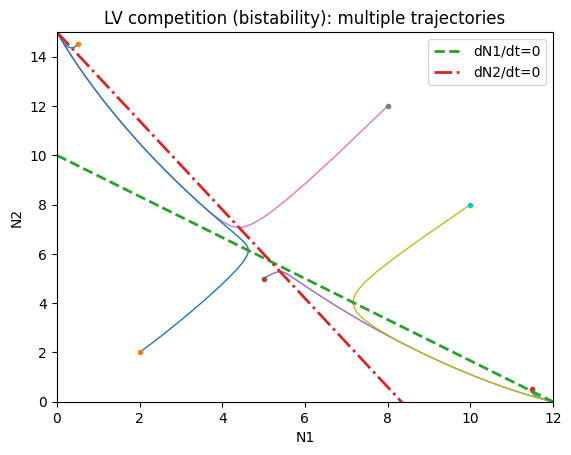

In [6]:
# Phase portrait for bistability
n1_grid = np.linspace(0, 12, 400)
iso1, iso2 = isoclines(n1_grid, k1_2, k2_2, a_2, b_2)

plt.figure()
for y0 in ([0.5,14.5],[11.5,0.5],[5,5],[8,12],[10,8],[2,2]):
    sol=solve_ivp(lv_rhs,(0,12),y0,t_eval=np.linspace(0,12,600),args=(r1,r2,k1_2,k2_2,a_2,b_2),rtol=1e-8,atol=1e-10)
    plt.plot(sol.y[0], sol.y[1], linewidth=1)
    plt.plot([y0[0]],[y0[1]], marker='o', markersize=3, linestyle='none')

plt.plot(n1_grid, iso1, '--', linewidth=2, label='dN1/dt=0')
plt.plot(n1_grid, iso2, '-.', linewidth=2, label='dN2/dt=0')
plt.xlim(0,12); plt.ylim(0,15)
plt.xlabel("N1"); plt.ylabel("N2")
plt.title("LV competition (bistability): multiple trajectories")
plt.legend()
plt.show()

### A minimal hysteresis model (positive feedback)

A standard toy model for catastrophic shifts is a linear input/loss term plus a saturating positive feedback (often represented with a Hill function). This class of models is used to illustrate how the *same* external driver can be associated with different equilibria depending on history (hysteresis).

$$
\dot x = a - b x + r f(x),\qquad
f(x)=\frac{x^p}{x^p+h^p}.
$$

- $a-bx$: linear input/loss
- $r f(x)$: positive feedback that saturates

For suitable $r$, this system can have **three equilibria** (two stable + one unstable), producing hysteresis.

We'll reproduce a simple “quasi-static” hysteresis loop by slowly increasing then decreasing $r$, each time re-using the last equilibrium as the initial condition.

References: {cite:t}`Scheffer2001`; {cite:t}`Scheffer2009`; {cite:t}`Strogatz1994`.


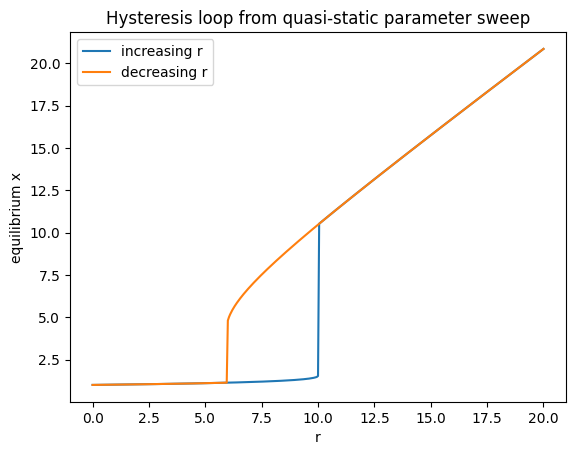

In [7]:
def hill(x, h=4, p=3):
    return x**p/(x**p + h**p)

def hyster_rhs(t, x, a=1, b=1, r=0, h=4, p=3):
    return a - b*x + r*hill(x, h=h, p=p)

def relax_equilibrium(r, x0, a=1, b=1, h=4, p=3):
    sol = solve_ivp(lambda t, x: hyster_rhs(t, x, a=a, b=b, r=r, h=h, p=p),
                    (0, 200), [x0], t_eval=np.linspace(0,200,2000),
                    rtol=1e-9, atol=1e-12)
    return sol.y[0,-1]

a=1; b=1; h=4; p=3
rs_up = np.linspace(0, 20, 401)
rs_dn = np.linspace(20, 0, 401)

x_up=[]
x=0.1
for r in rs_up:
    x=relax_equilibrium(r, x, a=a,b=b,h=h,p=p)
    x_up.append(x)

x_dn=[]
x=x_up[-1]
for r in rs_dn:
    x=relax_equilibrium(r, x, a=a,b=b,h=h,p=p)
    x_dn.append(x)

plt.figure()
plt.plot(rs_up, x_up, label="increasing r")
plt.plot(rs_dn, x_dn, label="decreasing r")
plt.xlabel("r"); plt.ylabel("equilibrium x")
plt.title("Hysteresis loop from quasi-static parameter sweep")
plt.legend()
plt.show()

#### Notes on the “missing branch”

The quasi-static sweep follows **stable equilibria only**.  
Where three equilibria exist, the middle one is unstable, so it will not be traced by forward integration.

Continuation tools (e.g., AUTO) can trace unstable branches. In Python, you can recover them by solving the equilibrium equation
$0 = a - bx + r f(x)$ with root finding using different initial guesses.

References: {cite:t}`Kuznetsov2004`; {cite:t}`Strogatz1994`.
